# Running a random forest regression to predict the host of crassphage

At this point of the workshop we should already have three tables: `crassphage-samples-information.txt`, `samples-species-taxonomy.txt`, and `samples-genus-taxonomy.txt`. We will use each one of the taxonomy tables to train a Random Forrest regression model, and see if we can predict possible hosts for crassphage.
In preparing this tutorial, I advised [this blog post](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/) by Fergus Boyles.

## Load the data

In [26]:
import pandas as pd

tax_level = 'species'
data_file = 'samples-'+ tax_level + '-taxonomy.txt'
target_file = 'crassphage-samples-information.txt'

raw_data = pd.DataFrame.from_csv(data_file, sep='\t')
target = pd.DataFrame.from_csv(target_file, sep='\t')

## Pre-process the data

First we remove all the samples that don't have crassphage (crassphage negative samples).

In [28]:
all_samples = raw_data.index
crassphage_positive_samples = target.index[target['presence']==True]
print('The number of samples in which crassphage was detected: %s' % len(crassphage_positive_samples))
crassphage_negative_samples = target.index[target['presence']==False]
print("The number of samples in which crassphage wasn't detected: %s" % len(crassphage_negative_samples))
# Keep only positive samples
samples = crassphage_positive_samples

The number of samples in which crassphage was detected: 80
The number of samples in which crassphage wasn't detected: 240
The number of taxons is 273
The number of qualifying taxons is 69


Ok, so there a lot more negative samples than positive samples.

Let's look at where are the positive samples coming from.

In [3]:
for o in ['USA', 'CHI', 'FIJ', 'TAN']:
    a = len([s for s in crassphage_positive_samples if s.startswith(o)])
    b = len([s for s in all_samples if s.startswith(o)])
    c = a/b * 100
    print('The number of crassphage positive samples from %s is %s out of total %s (%0.f%%)' % (o, a, b, c))

The number of crassphage positive samples from USA is 53 out of total 103 (51%)
The number of crassphage positive samples from CHI is 16 out of total 46 (35%)
The number of crassphage positive samples from FIJ is 11 out of total 167 (7%)
The number of crassphage positive samples from TAN is 0 out of total 8 (0%)


We can see that crassphage is most prevalent in the US cohort, but also quite common in the Chinese cohort. Whereas it is nearly absent from the Fiji cohort, and completely absent from the eight hunter gatherers from Tanzania. Now we remove the taxons that don't occur in at least 3 of the crassphage positive samples.

In [42]:
occurence_in_positive_samples = raw_data.loc[crassphage_positive_samples,]
qualifying_taxons = raw_data.columns[(occurence_in_positive_samples>0).sum()>3]
portion = len(qualifying_taxons)/len(raw_data.columns) * 100
print('The number of qualifying taxons is %s out of total %s (%0.f%%)' % (len(qualifying_taxons), \
                                                                         len(raw_data.columns), \
                                                                         portion))

data = raw_data.loc[samples, qualifying_taxons]

The number of qualifying taxons is 69 out of total 273 (25%)


## Train model
We now train a Random Forrest regression model on the clean data. The input data for the model are the abundances from KrakenHLL, and the target data for prediction is the non-outlier mean coverage of crassphage.

In [44]:
from sklearn import ensemble
n_trees = 64
RF = ensemble.RandomForestRegressor(n_trees, \
                                    oob_score=True, \
                                    random_state=1)

RF.fit(data,target.loc[samples,'non_outlier_mean_coverage'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

## Model Results

The model finished, let's check the oob value (a kind of R^2 estimation for the model. For more details refer to [this part of the scikit-learn docummentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score).

In [46]:
RF.oob_score_

0.10409841701423317

Let's look at the importance of the features:

In [47]:
import numpy as np
features_according_to_order_of_importance = data.columns[np.argsort(-RF.feature_importances_)]

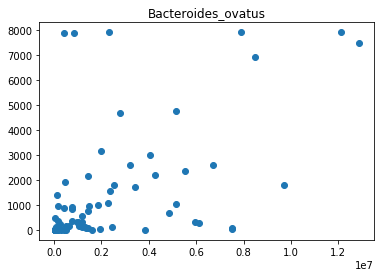

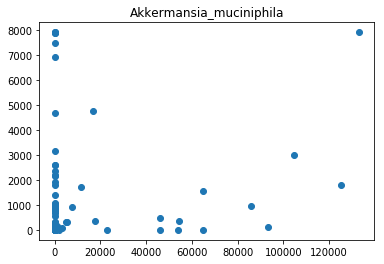

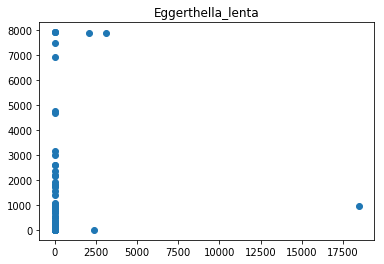

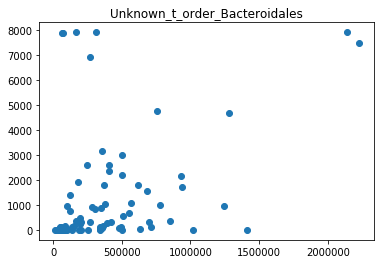

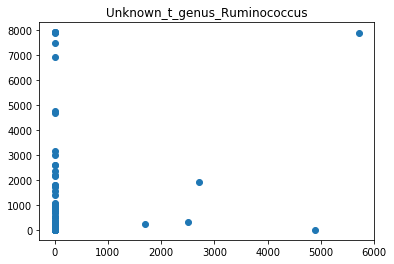

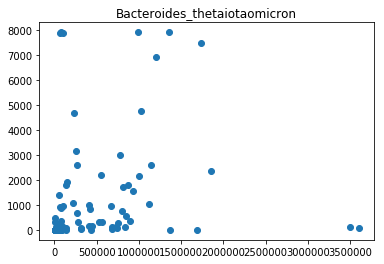

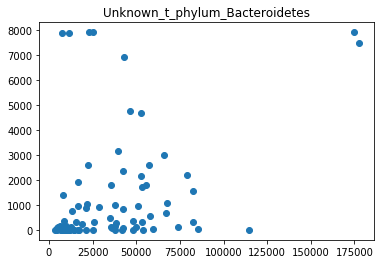

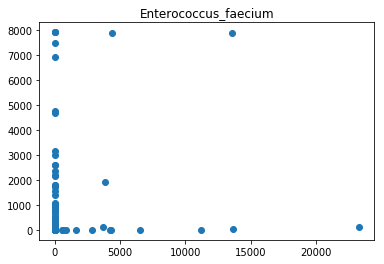

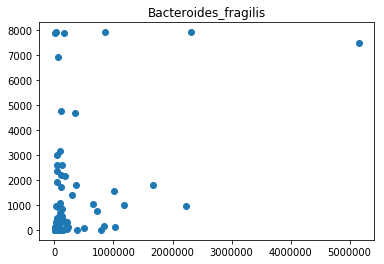

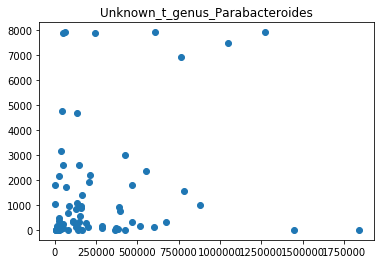

In [52]:
from matplotlib import pyplot as plt
g = features_according_to_order_of_importance[0:10]
for f in g:
    plt.figure()
    plt.scatter(data.loc[data[f].sort_values().index,f], \
                target.loc[data[f].sort_values().index,'non_outlier_mean_coverage'])
    plt.title(f)
    plt.show()

We can see that a lot of members and close relatives of the _Bacteroides_ genus are included, which is encouraging. In addition, a few other things are included, but we need to remember that in a regression model things that anti-correlate could also count as important features.

## Does this model actually have predictive stretgh?
So far we created a model with all of our data and estimated how good it fits the data. Now let's we will train a regression model on a subset of the samples and test it on a test subset.

We first create the subsets of the samples:

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, \
                                                    target.loc[samples,'non_outlier_mean_coverage'], \
                                                    train_size=0.8, \
                                                    random_state=42)

RF = ensemble.RandomForestRegressor(n_trees, oob_score=True, random_state=1)
RF.fit(X_train, y_train)
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = RF.predict(X_train)
predicted_test = RF.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {RF.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.0855
Test data R-2 score: 0.129
Test data Spearman correlation: 0.341
Test data Pearson correlation: 0.46


/Users/alonshaiber/virtual-envs/anvio-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Ok, so we can see that this model doesn't really have predictive stregth, and yet it did a pretty good job finding the important taxons.

## Trying another approach
We will try a hierarchical clustering approach similar to what was done in the crassphage paper.

First we will merge the data together (i.e. add the crassphage coverage as a column to the kraken table):

In [40]:
# add the crassphage column
merged_df = pd.concat([data, target.loc[samples,"non_outlier_mean_coverage"]], axis=1)
# Changing the name of the crassphage column
merged_df.columns = list(merged_df.columns[:-1]) + ['crassphage']
# Write as TAB-delimited

# anvi'o doesn't like charachters that are not alphanumeric or '_'
# so we will fix index and column labels
import re
f = lambda x: x if x.isalnum() else '_'
merged_df.columns = [re.sub('\_+', '_', ''.join([f(ch) for ch in s])) for s in list(merged_df.columns)]
merged_df.index = [re.sub('\_+', '_', ''.join([f(ch) for ch in s])) for s in list(merged_df.index)]

# Save data to a TAB-delimited file
merged_df.to_csv(tax_level + '-matrix.txt', sep='\t', index_label = 'sample')

Now we leave the python notebook and go back to the command line.